# There are three approaches to segmentation:

### The first is agnostic of space and examines the intensity distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nibabel as nib
T1w_img = nib.load('991267-T1w_acpc_dc_detrend_quadratic.nii.gz')
T1w_data = T1w_img.get_data()

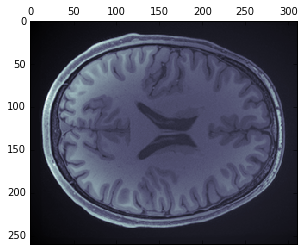

In [3]:
plt.matshow(T1w_data[:, :, T1w_data.shape[-1]//2], cmap='bone')

# Introducing Scikit Image:

... 

In [4]:
from skimage import exposure

In [5]:
hist, bin_centers = exposure.histogram(T1w_data.ravel())

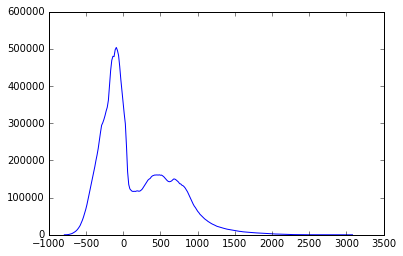

In [6]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)
fig.savefig('../fig/segmentation01.png')


# Otsu's method for segmentation

https://en.wikipedia.org/wiki/Otsu%27s_method

Assumes there are two classes of voxels: background and foreground

The class probabilities as a function of the threshold $t$ are the cumulative sums of the distributions up to that point:

$w_1(t) = \sum_{i=1}^{t-1} \frac{hist(i)}{L}$

$w_2(t) = \sum_{i=t}^{L-1} \frac{hist(i)}{L} $

where L is the total number of pixels

In [7]:
# Normalize the histogram to sum to 1:
hist = hist.astype(float) / np.sum(hist)

# class probabilities for all possible thresholds
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

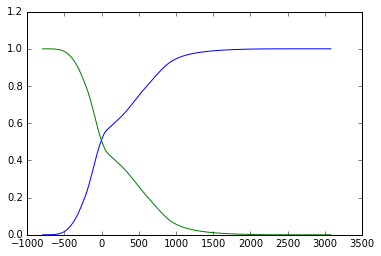

In [8]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, weight1)
ax.plot(bin_centers, weight2)
fig.savefig('../fig/segmentation02.png')

Otsu's method relies on finding a threshold that  minimizes the intra-class variance: 

$\sigma^2_w = w_1 \sigma^2_1 + w_2 \sigma^2_2$

Importantly, minimizing intra-class variance, is equivalent to maximizing inter-class variance. 

That is becauase: 

$\sigma^2 = \sigma^2_w + \sigma^2_b$

That's because the sum of squares is always constant.

$\sigma^2_b = \sigma^2 - \sigma^2_w = w_1 (\mu_1 - \mu)^2 + w_2 (\mu_2 - \mu)^2 = w_1 w_2 (\mu_1 - \mu_2)^2$ 


Where 

$\mu_1 = \sum_{i}^{t-1} \frac{i p(i)}{w_1}$

$\mu_2 = \sum_{t}^{L-1} \frac{i p(i)}{w_2}$



In [9]:
# class means for all possible thresholds
mean1 = np.cumsum(hist * bin_centers) / weight1
mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]

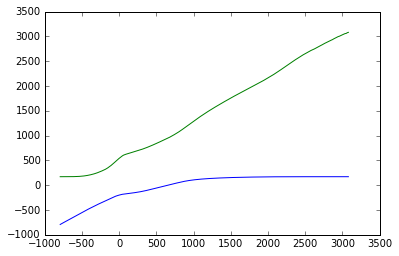

In [10]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, mean1)
ax.plot(bin_centers, mean2)

In [11]:
# The last value of `weight1`/`mean1` should pair with zero values in
# `weight2`/`mean2`, which do not exist.
variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

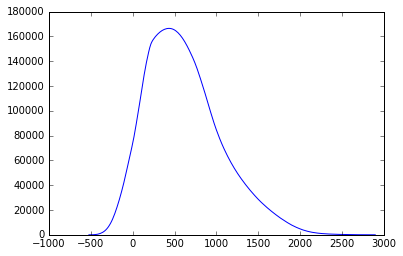

In [49]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers[:-1], variance12)
fig.savefig('../fig/segmentation02_b.png')


In [13]:
idx = np.argmax(variance12)
threshold = bin_centers[:-1][idx]

In [14]:
threshold

286.68663288439473

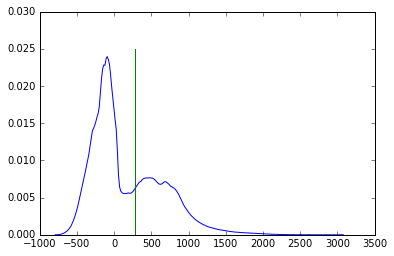

In [15]:
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)
ax.plot([threshold, threshold], [0, ax.get_ylim()[1]])
fig.savefig('../fig/segmentation03.png')

In [16]:
binary = T1w_data >= threshold

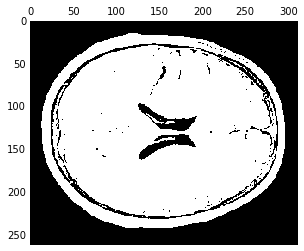

In [17]:
fig, ax = plt.subplots()
ax.matshow(binary[:, :, binary.shape[-1]//2], cmap='bone')
fig.savefig('../fig/segmentation04.png')

In [18]:
from skimage import filters

In [19]:
#filters.threshold_<tab>

skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata


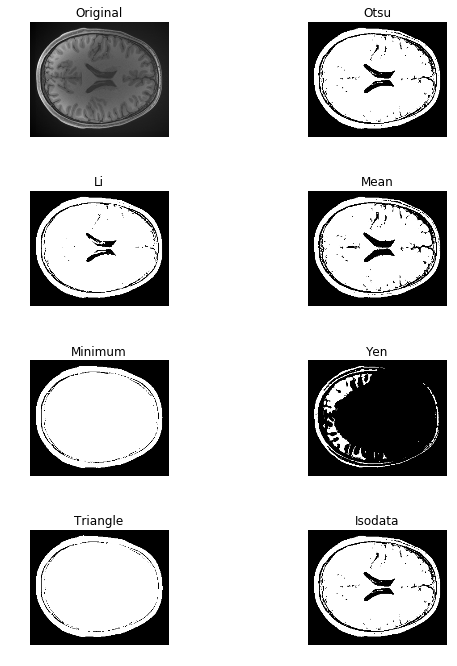

In [20]:
fig, ax = filters.thresholding.try_all_threshold(T1w_data[:, :, T1w_data.shape[-1]//2])
fig.set_size_inches([10, 10])
fig.savefig('../fig/segmentation05.png')

# The other is based on finding edges

Explain filtering and convolution here

In [21]:
im = T1w_data[:, :, T1w_data.shape[-1]//2]

In [22]:
from skimage import feature

In [23]:
edges = feature.canny(binary[:, :, binary.shape[-1]//2], sigma=1, mask=binary[:, :, binary.shape[-1]//2])
edges = feature.canny(im, sigma=2, mask=binary[:, :, binary.shape[-1]//2])

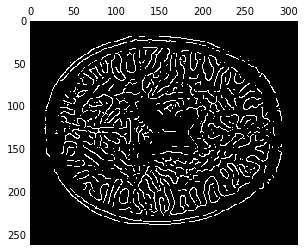

In [24]:
plt.matshow(edges, cmap='bone')

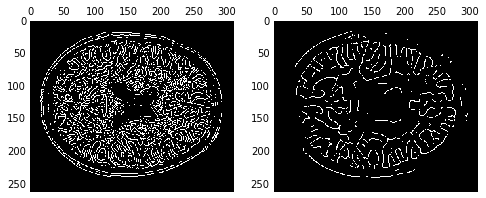

In [25]:
edges1 = feature.canny(im, sigma=1, mask=binary[:, :, binary.shape[-1]//2])
edges4 = feature.canny(im, sigma=4, mask=binary[:, :, binary.shape[-1]//2])
fig, ax = plt.subplots(1, 2)
ax[0].matshow(edges1, cmap='bone')
ax[1].matshow(edges4, cmap='bone')
fig.set_size_inches([8, 8])
fig.savefig('../fig/segmentation06.png')

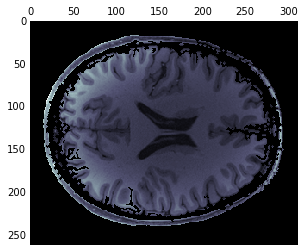

In [26]:
from scipy import ndimage as ndi
dilated = ndi.binary_dilation(edges1, iterations=1)
fill_brain = ndi.binary_fill_holes(dilated)
brain = np.zeros(im.shape)
brain[fill_brain] = im[fill_brain]
fig, ax = plt.subplots(1)
ax.matshow(brain, cmap='bone')
fig.savefig('../fig/segmentation07.png')

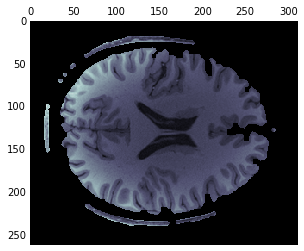

In [27]:
edges = feature.canny(binary[:, :, binary.shape[-1]//2],
                      sigma=1, mask=binary[:, :, binary.shape[-1]//2])

dilated = ndi.binary_dilation(edges, iterations=1)
fill_brain = ndi.binary_fill_holes(dilated)
brain = np.zeros(im.shape)
brain[fill_brain] = im[fill_brain]
fig, ax = plt.subplots(1)
ax.matshow(brain, cmap='bone')
fig.savefig('../fig/segmentation08.png')

In [28]:
from scipy import ndimage as ndi

In [29]:
#dilated = ndi.binary_dilation(edges, iterations=4)
dilated = ndi.binary_dilation(edges, iterations=1)

In [30]:
fill_brain = ndi.binary_fill_holes(dilated)

In [31]:
sl = np.zeros(im.shape)
sl[fill_brain] = im[fill_brain]

In [32]:
edges = feature.canny(binary[:, :, binary.shape[-1]//2],
                      sigma=1, mask=binary[:, :, binary.shape[-1]//2])

dilated = ndi.binary_dilation(edges, iterations=1)
fill_brain = ndi.binary_fill_holes(dilated)


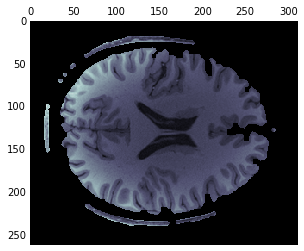

In [33]:
plt.matshow(sl, cmap='bone')

In [34]:
elevation_map = filters.edges.sobel(im, mask=binary[:, :, binary.shape[-1]//2])

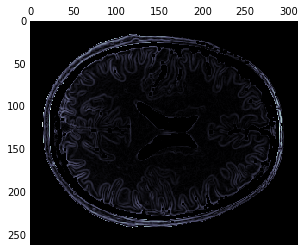

In [35]:
plt.matshow(elevation_map, cmap='bone')

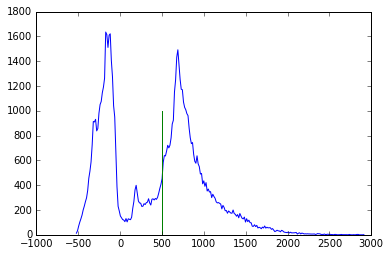

In [36]:
hist, bin_centers = exposure.histogram(im)
fig, ax = plt.subplots(1)
ax.plot(bin_centers, hist)
ax.plot([500, 500], [0, 1000])

In [37]:
markers = np.zeros(elevation_map.shape)
markers[im < 0] = 1
markers[im > 800] = 2

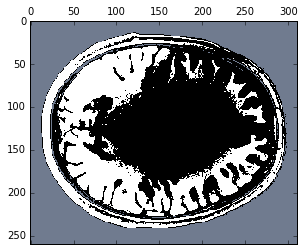

In [38]:
plt.matshow(markers, cmap='bone')

In [39]:
from skimage import morphology

In [40]:
segmentation = morphology.watershed(elevation_map, markers)

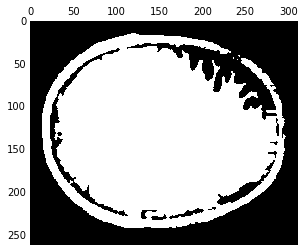

In [41]:
plt.matshow(segmentation, cmap='bone')

In [42]:
from skimage import data, segmentation

In [43]:
from skimage.future import graph

In [44]:
labels = segmentation.slic(im)

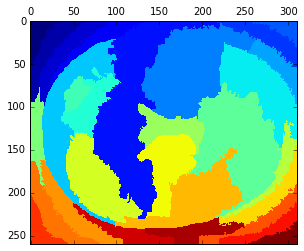

In [45]:
plt.matshow(labels)

In [46]:
rag = graph.rag_mean_color(im, labels, mode='similarity')

In [47]:
new_labels = graph.cut_normalized(labels, rag, thresh=1, num_cuts=100)

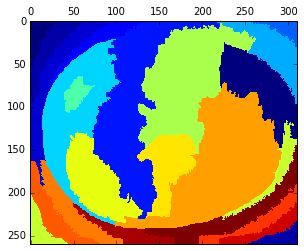

In [48]:
plt.matshow(new_labels)